This post is to demo the use of quantile regression analysis. As an example, we'll use a dataset where it is almost impossible to learn anything about the data using standard linear regression techniques. These methods were developed during a few weeks of work I recently completed for the Bridger-Teton Avalanche Center. Below is the code for 1st, 2nd, and 3rd-order polynomial linear regression, confidence and prediction intervals, and quantile regression.

Thanks to Josef Perktold at StatsModels for assistance with the quantile regression code, and providing the creative "heteroscedastic" dataset that we will analyze. (you'll have to look that word up on your own....)

First, let's generate some random data, and attempt to do some standard linear regression. We'll treat this as a correlation analysis, and call the x data 'predictor' and the y data 'response'.

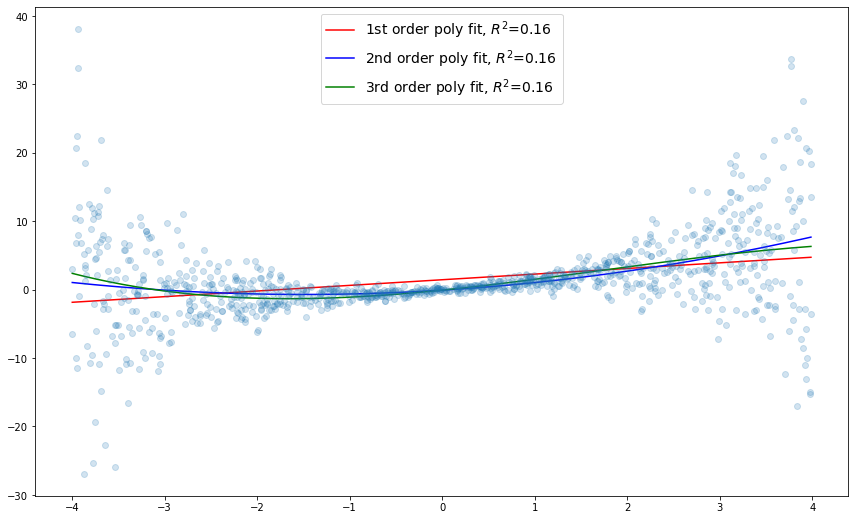

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf

np.random.seed(654123)

# generate a random dataset with heteroscedasticity
nobs = 1000
x = np.random.uniform(-4, 4, nobs)
y = x + 0.25 * x**2 + 0.1 * np.exp(1 + np.abs(x)) * np.random.randn(nobs)
 
df = pd.DataFrame({'predictor': x, 'response': y})

x1 = pd.DataFrame({'predictor': np.linspace(df.predictor.min(), df.predictor.max(), nobs)})

poly_1 = smf.ols(formula='response ~ 1 + predictor', data=df).fit()
poly_2 = smf.ols(formula='response ~ 1 + predictor + I(predictor ** 2.0)', data=df).fit()
poly_3 = smf.ols(formula='response ~ 1 + predictor + I(predictor ** 2.0) + I(predictor ** 3.0)', data=df).fit()

plt.figure(figsize=(9 * 1.618, 9))
plt.plot(x1.predictor, poly_1.predict(x1), 'r-', 
         label='1st order poly fit, $R^2$=%.2f' % poly_2.rsquared)
plt.plot(x1.predictor, poly_2.predict(x1), 'b-', 
         label='2nd order poly fit, $R^2$=%.2f' % poly_2.rsquared)
plt.plot(x1.predictor, poly_3.predict(x1), 'g-', 
         label='3rd order poly fit, $R^2$=%.2f' % poly_2.rsquared)

plt.plot(x, y, 'o', alpha=0.2)
plt.legend(loc="upper center", fontsize=14)



With this particular dataset we learn almost nothing about the variability of the data from the linear regression models. Let's proceed with the 2nd order polynomial model, and have a look at confidence and prediction intervals. We'll also use the very nicely-formatted summary table from StatsModels to evaluate the polynomial fit.

                            OLS Regression Results                            
Dep. Variable:               response   R-squared:                       0.161
Model:                            OLS   Adj. R-squared:                  0.160
Method:                 Least Squares   F-statistic:                     95.99
Date:                Wed, 13 Oct 2021   Prob (F-statistic):           7.48e-39
Time:                        09:13:02   Log-Likelihood:                -3096.3
No. Observations:                1000   AIC:                             6199.
Df Residuals:                     997   BIC:                             6213.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              -0.0845    

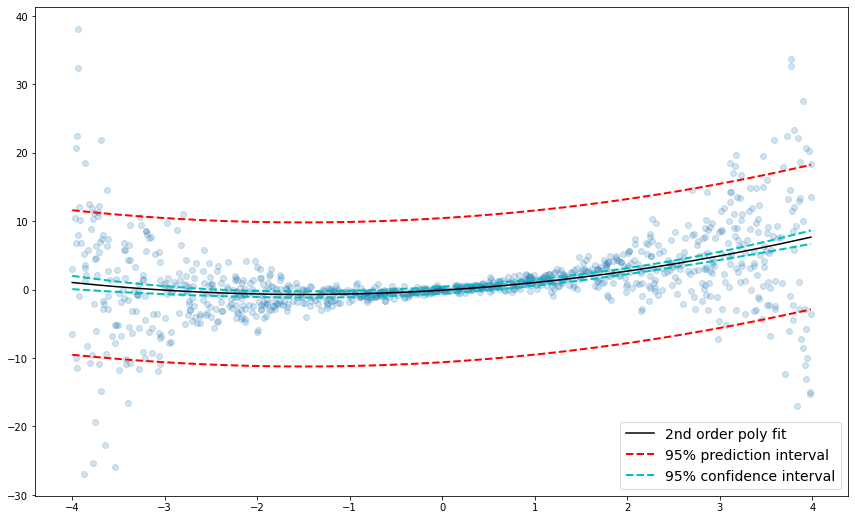

In [2]:
# CI and PI for 2nd order poly:

from statsmodels.stats.outliers_influence import summary_table
from statsmodels.sandbox.regression.predstd import wls_prediction_std

plt.figure(figsize=(9 * 1.618, 9))
plt.plot(x, y, 'o', alpha=0.2, label='')


plt.plot(x1.predictor, poly_2.predict(x1), 'k-', label='2nd order poly fit')
print(poly_2.summary())

prstd, iv_l, iv_u = wls_prediction_std(poly_2)

st, data, ss2 = summary_table(poly_2, alpha=0.05)

fittedvalues = data[:,2]
predict_mean_se  = data[:,3]
predict_mean_ci_low, predict_mean_ci_upp = data[:,4:6].T
predict_ci_low, predict_ci_upp = data[:,6:8].T

# check we got the right things
#print np.max(np.abs(poly_2.fittedvalues - fittedvalues))
#print np.max(np.abs(iv_l - predict_ci_low))
#print np.max(np.abs(iv_u - predict_ci_upp))

data_intervals = {'predictor': x, 'predict_low': predict_ci_low, 'predict_upp': predict_ci_upp,
                  'conf_low': predict_mean_ci_low, 'conf_high': predict_mean_ci_upp}
df_intervals = pd.DataFrame(data=data_intervals)

df_intervals_sort = df_intervals.sort_values(by='predictor')

#embed()

plt.plot(df_intervals_sort.predictor, df_intervals_sort.predict_low,
         color='r', linestyle='--', linewidth=2, label='95% prediction interval')
plt.plot(df_intervals_sort.predictor, df_intervals_sort.predict_upp,
         color='r', linestyle='--', linewidth=2, label='')
plt.plot(df_intervals_sort.predictor, df_intervals_sort.conf_low,
         color='c', linestyle='--', linewidth=2, label='95% confidence interval')
plt.plot(df_intervals_sort.predictor, df_intervals_sort.conf_high,
         color='c', linestyle='--', linewidth=2, label='')

plt.legend(fontsize=14)